In [1]:
# 必要なライブラリのインポート

# NumPy：数値計算用ライブラリ（行列演算など）
import numpy as np

# random：乱数生成用の標準ライブラリ（再現性確保のためにseed固定などに使う）
import random

# PyTorch本体と損失関数（Functional API）をインポート
import torch
import torch.nn.functional as F

# PyTorch Geometric のGCN層（グラフ畳み込み層）をインポート
from torch_geometric.nn import GCNConv

# PyTorch Geometric のベンチマーク用データセット Planetoid（Cora, CiteSeer, PubMedなど）を使用
from torch_geometric.datasets import Planetoid

# networkx：グラフ構造の可視化に使うライブラリ（ノードとエッジの関係を直感的に描画できる）
import networkx as nx

# matplotlib：グラフ可視化ライブラリ
import matplotlib.pyplot as plt

# sklearnのTSNE：高次元ベクトル（特徴量）を2次元空間に圧縮するための次元削減手法（可視化目的）
from sklearn.manifold import TSNE

In [2]:
# 再現性（再実行時に同じ結果が得られるように）を確保するために、各種乱数シードを固定する

torch.manual_seed(0)  # PyTorchの乱数シードを0に設定
np.random.seed(0)  # NumPyの乱数シードを0に設定
random.seed(0)  # Python標準ライブラリ random の乱数シードを0に設定

In [3]:
# Planetoid（論文用のベンチマークデータセット）から「Cora」データセットを読み込む
dataset = Planetoid(root="/tmp/Cora", name="Cora")
# Cora：論文間の引用ネットワーク。各ノードは論文、エッジは引用関係、特徴ベクトルとクラスラベルを持つ

# データセット内のグラフに含まれるノード数（論文数）を取得
n = dataset[0].num_nodes

Processing...
Done!


In [4]:
# ===============================
# グラフ畳み込みネットワーク（GCN）の定義
# ===============================
class GCN(torch.nn.Module):
    def __init__(self, in_d, mid_d, out_d):
        super().__init__()

        # 1層目のGCN（入力次元 → 中間次元）
        self.conv1 = GCNConv(in_d, mid_d)

        # 2層目のGCN（中間次元 → 出力次元：クラス数）
        self.conv2 = GCNConv(mid_d, out_d)

    def forward(self, data):
        # 特徴行列（ノードごとの特徴ベクトル）とエッジ情報を取得
        x, edge_index = data.x, data.edge_index

        # 1層目のGCN：ノード特徴を伝播
        x = self.conv1(x, edge_index)

        # 学習済みの中間特徴（埋め込み）を保存（勾配を追跡しない）
        emb = x.detach()

        # 非線形活性化関数ReLUを適用
        x = F.relu(x)

        # 2層目のGCNを通してクラススコア（未正規化）を計算
        x = self.conv2(x, edge_index)

        # log softmaxでクラス分類用の確率スコアに変換（負の対数尤度損失と合わせて使う）
        return F.log_softmax(x, dim=1), emb

In [5]:
# ===============================
# GCNモデルのインスタンス化
# ===============================

# 入力次元数：ノードの特徴量の数（Coraデータセットでは1433次元）
in_d = dataset.num_node_features

# 中間層の次元数：ここでは任意に16次元に設定（埋め込みの次元数）
mid_d = 16

# 出力次元数：分類対象のクラス数（Coraデータセットでは7クラス）
out_d = dataset.num_classes

# モデルを構築（2層のGCN：in_d → 16 → out_d）
model = GCN(in_d, mid_d, out_d)

In [6]:
# ===============================
# データの取得と最適化アルゴリズムの設定
# ===============================

# Planetoidデータセットは1つの大きなグラフを含むため、dataset[0] でその唯一のデータオブジェクトを取得
# data は以下の情報を含む：
# - data.x: ノードの特徴量（[num_nodes, num_node_features]のテンソル）
# - data.edge_index: エッジ情報（[2, num_edges]のテンソル）
# - data.y: 各ノードのラベル
# - data.train_mask / val_mask / test_mask: 各ノードがどの分割（学習/検証/テスト）に属するかを示すブールマスク
data = dataset[0]

# 最適化手法として確率的勾配降下法（SGD）を使用
# - model.parameters(): 学習対象のすべてのパラメータ
# - lr=0.1: 学習率（Learning Rate）
# - weight_decay=1e-4: L2正則化の強さ（過学習防止）
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, weight_decay=1e-4
)  # ===============================
# データの取得と最適化アルゴリズムの設定
# ===============================

# Planetoidデータセットは1つの大きなグラフを含むため、dataset[0] でその唯一のデータオブジェクトを取得
# data は以下の情報を含む：
# - data.x: ノードの特徴量（[num_nodes, num_node_features]のテンソル）
# - data.edge_index: エッジ情報（[2, num_edges]のテンソル）
# - data.y: 各ノードのラベル
# - data.train_mask / val_mask / test_mask: 各ノードがどの分割（学習/検証/テスト）に属するかを示すブールマスク
data = dataset[0]

# 最適化手法として確率的勾配降下法（SGD）を使用
# - model.parameters(): 学習対象のすべてのパラメータ
# - lr=0.1: 学習率（Learning Rate）
# - weight_decay=1e-4: L2正則化の強さ（過学習防止）
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [7]:
def train(epoch_count):
    """
    指定されたエポック数だけモデルを訓練する関数。
    """
    model.train()  # 訓練モードに設定することで、Dropoutなどが有効になる。

    for epoch in range(epoch_count):
        optimizer.zero_grad()  # 前回の勾配をリセットして累積を防止する。

        out = model(data)[0]  # モデルによる順伝播を実行し、出力の対数確率を取得する。

        # 訓練用マスクがTrueのノードのみを対象に損失を計算する。
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

        loss.backward()  # 誤差逆伝播により勾配を計算する。

        optimizer.step()  # 計算された勾配を用いてパラメータを更新する。

In [8]:
# ===== 実行時間の計測（Jupyter Magic: %time） =====
# 以下のように記述すると、train(500) を一度だけ実行し、その実行時間を測定できる
%time train(500)

CPU times: user 3.31 s, sys: 703 ms, total: 4.02 s
Wall time: 2.63 s


In [9]:
# 評価モードに切り替える（Dropoutなどを無効化し、推論時の挙動に変更）
model.eval()

# モデルにデータを入力して、出力のうちロジット（対数確率）を取得
# model(data) は (logits, emb) を返すタプルなので、[0] で logits を抽出
pred: torch.Tensor = model(data)[0].argmax(dim=1)
# 出力テンソルから最も確率が高いクラスのインデックスを取り出す（分類ラベル）

# テストデータにおける予測と正解ラベルを比較し、正解した個数をカウント
correct: torch.Tensor = (pred[data.test_mask] == data.y[data.test_mask]).sum()

# 正解数をテストデータの総数で割り、精度（accuracy）を計算
acc: float = int(correct) / int(data.test_mask.sum())

# 精度を出力
acc

0.805

In [10]:
# 空の無向グラフを作成
G: nx.Graph = nx.Graph()

# ノード数 n 個をグラフに追加
for i in range(n):
    G.add_node(i)  # ノード i を追加

# PyTorch Geometric の edge_index を使ってエッジを追加
# edge_index[0, i] が始点、edge_index[1, i] が終点を表す
for i in range(data.edge_index.shape[1]):
    src: int = int(data.edge_index[0, i])  # エッジの始点ノード
    dst: int = int(data.edge_index[1, i])  # エッジの終点ノード
    G.add_edge(src, dst)  # エッジ（src → dst）を無向グラフに追加

In [11]:
# ノードのラベル（クラス）に応じた色を設定するためのリスト
colors: list[str] = [
    "#ff4b00",  # クラス0用の色（オレンジ）
    "#03af7a",  # クラス1用の色（緑）
    "#005aff",  # クラス2用の色（青）
    "#4dc4ff",  # クラス3用の色（水色）
    "#f6aa00",  # クラス4用の色（黄色）
    "#990099",  # クラス5用の色（紫）
    "#804000",  # クラス6用の色（茶色）
]

# ノードごとにラベル y に対応する色を割り当てる
# data.y は各ノードのクラスラベルを格納したテンソル（例: tensor([3, 2, 1, ...])）
cs: list[str] = [colors[int(y)] for y in data.y]

In [12]:
# ===============================
# GCNから得られたノードの隠れ層埋め込みを t-SNE によって2次元に次元削減する処理
# ===============================

# 型ヒント:
# - emb: np.ndarray  # ノード数 × 中間次元数 の行列
# - emb_tsne: np.ndarray  # ノード数 × 2 の2次元埋め込み結果

# GCNの1層目から得られたノードの埋め込み特徴を NumPy 配列に変換
emb: np.ndarray = model(data)[1].detach().numpy()

# t-SNE インスタンスの生成
# - n_components=2: 2次元に削減
# - random_state=0: 結果の再現性を確保
# - init='pca': 初期配置にPCAを使用（収束を早める）
# - learning_rate="auto": PyTorch互換の推奨設定（バージョンによって推奨される）
tsne: TSNE = TSNE(n_components=2, random_state=0, init="pca", learning_rate="auto")

# 埋め込み特徴を2次元空間に変換（各ノードの可視化用座標を得る）
emb_tsne: np.ndarray = tsne.fit_transform(emb)

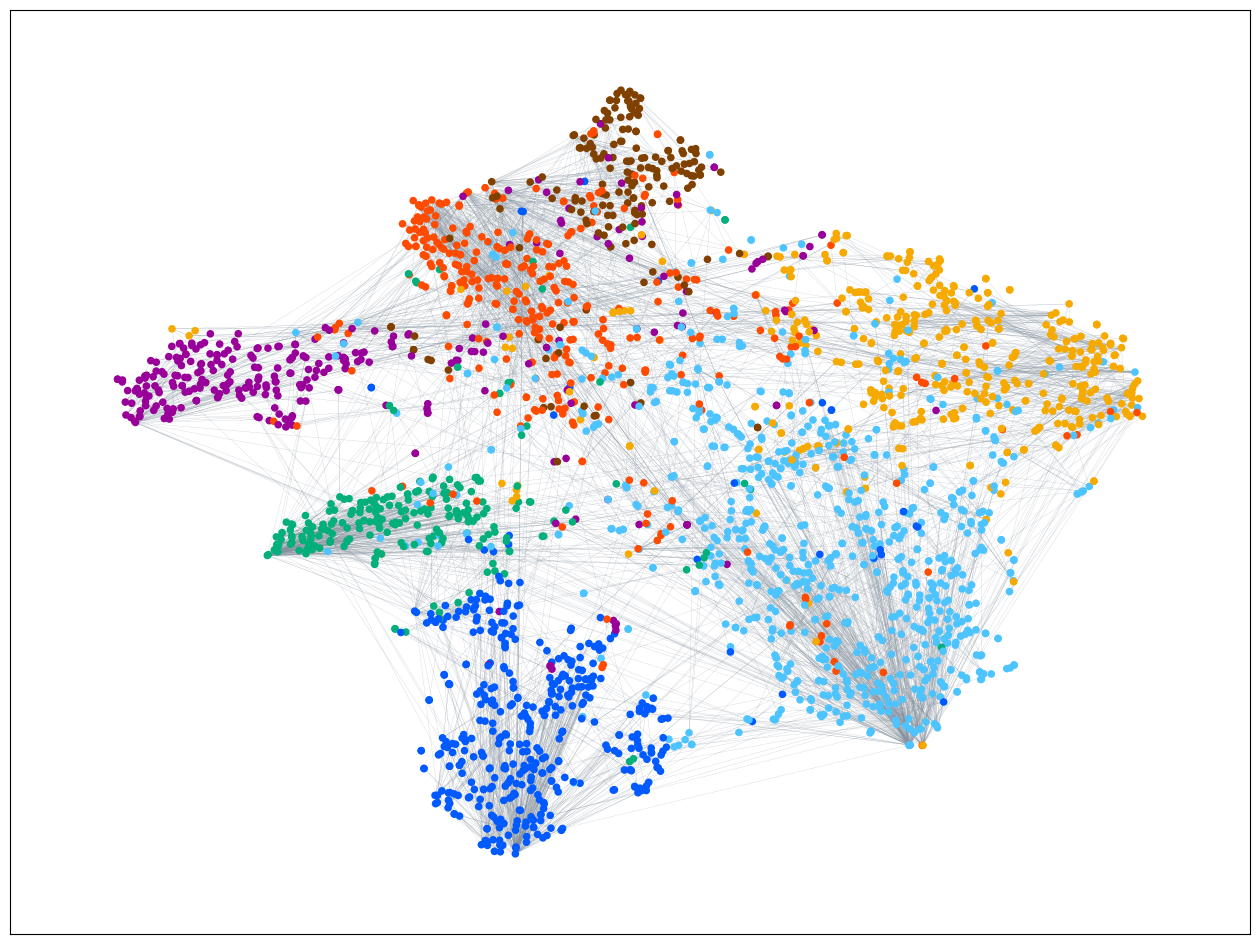

In [13]:
# GCN によって得られたノード埋め込みを 2 次元に可視化する
# 可視化には networkx の draw_networkx を使用する

# 描画用のキャンバス（fig）と描画領域（ax）を用意（サイズは大きめに設定）
fig, ax = plt.subplots(figsize=(16, 12))

# グラフ描画
nx.draw_networkx(
    G,  # networkx のグラフオブジェクト（ノード・エッジ情報を保持）
    ax=ax,  # 描画先の座標軸
    pos=emb_tsne,  # 各ノードの2次元座標（TSNEなどで次元削減したもの）
    node_size=20,  # ノードの大きさを小さめに設定（視認性のため）
    node_color=cs,  # ノードの色はクラスに応じて定義した色リスト cs を使用
    labels={
        i: "" for i in range(n)
    },  # ラベルは非表示（空文字列にすることで全ノード無表示）
    edge_color="#84919e",  # エッジの色をグレー系に設定
    width=0.1,  # エッジの線幅を細くする（密なグラフの視認性向上）
)

In [14]:
# t-SNE による次元圧縮を行う関数
tsne: TSNE = TSNE(
    n_components=2, random_state=0
)  # 2次元への圧縮。ランダムシードを固定して再現性を確保

# 入力特徴量（data.x）をt-SNEで2次元に圧縮（data.xは各ノードの特徴ベクトル）
X_tsne: np.ndarray = tsne.fit_transform(data.x)

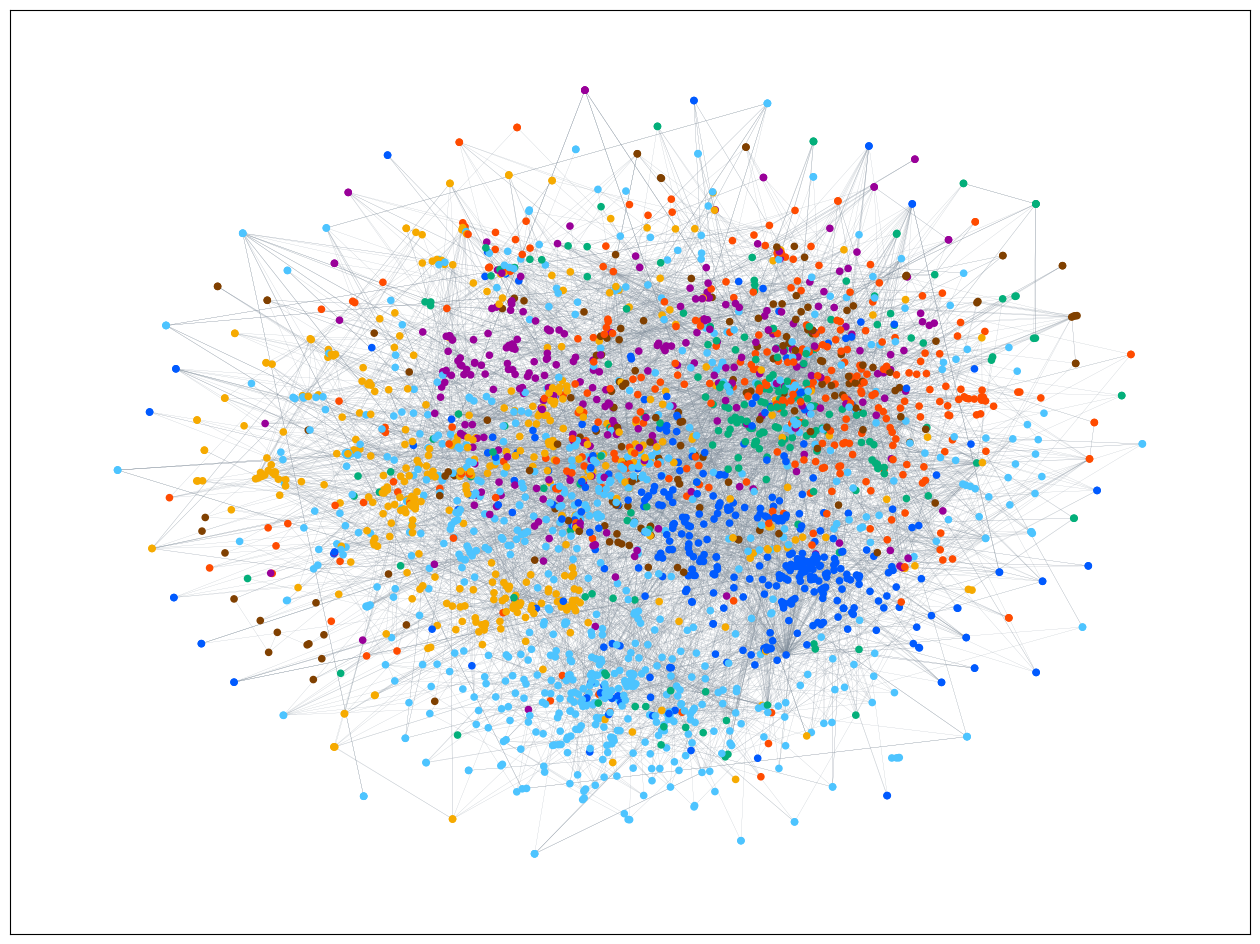

In [15]:
# 頂点特徴 X の2次元埋め込み（t-SNEによって次元圧縮されたもの）を用いてネットワークを可視化する
fig, ax = plt.subplots(figsize=(16, 12))  # 描画サイズを指定して図と座標軸を作成

# ネットワーク構造を描画
# - G: グラフ構造（NetworkXオブジェクト）
# - pos: 各ノードの2次元座標（X_tsne）
# - node_size: ノードの大きさを 20 に設定
# - node_color: ラベルに基づいたノードの色リスト（cs）
# - labels: ノードラベルは非表示にする（空文字）
# - edge_color: 辺の色をグレー系に指定
# - width: 辺の太さを 0.1 に設定して細く表示
nx.draw_networkx(
    G,
    ax=ax,
    pos=X_tsne,  # 各ノードの2次元座標（t-SNEで変換された特徴ベクトル）
    node_size=20,
    node_color=cs,  # 各ノードの色（クラスラベルに基づく）
    labels={i: "" for i in range(n)},  # ラベル非表示
    edge_color="#84919e",
    width=0.1,
)

In [16]:
# GCNの第1層の線形変換（GCNConv内の重み行列）を使って、特徴量を変換する
# data.x: 各ノードの特徴行列（[ノード数 × 入力次元]）
# model.conv1.lin.weight: 第1層の線形変換の重み（[中間次元 × 入力次元]）
# 転置して行列積を取ることで、各ノードに対して新しい特徴ベクトル H を得る
H: np.ndarray = (data.x @ model.conv1.lin.weight.T).detach().numpy()

# t-SNE によって、GCNの第1層出力（H）を2次元に次元削減
tsne = TSNE(n_components=2, random_state=0)
H_tsne: np.ndarray = tsne.fit_transform(H)

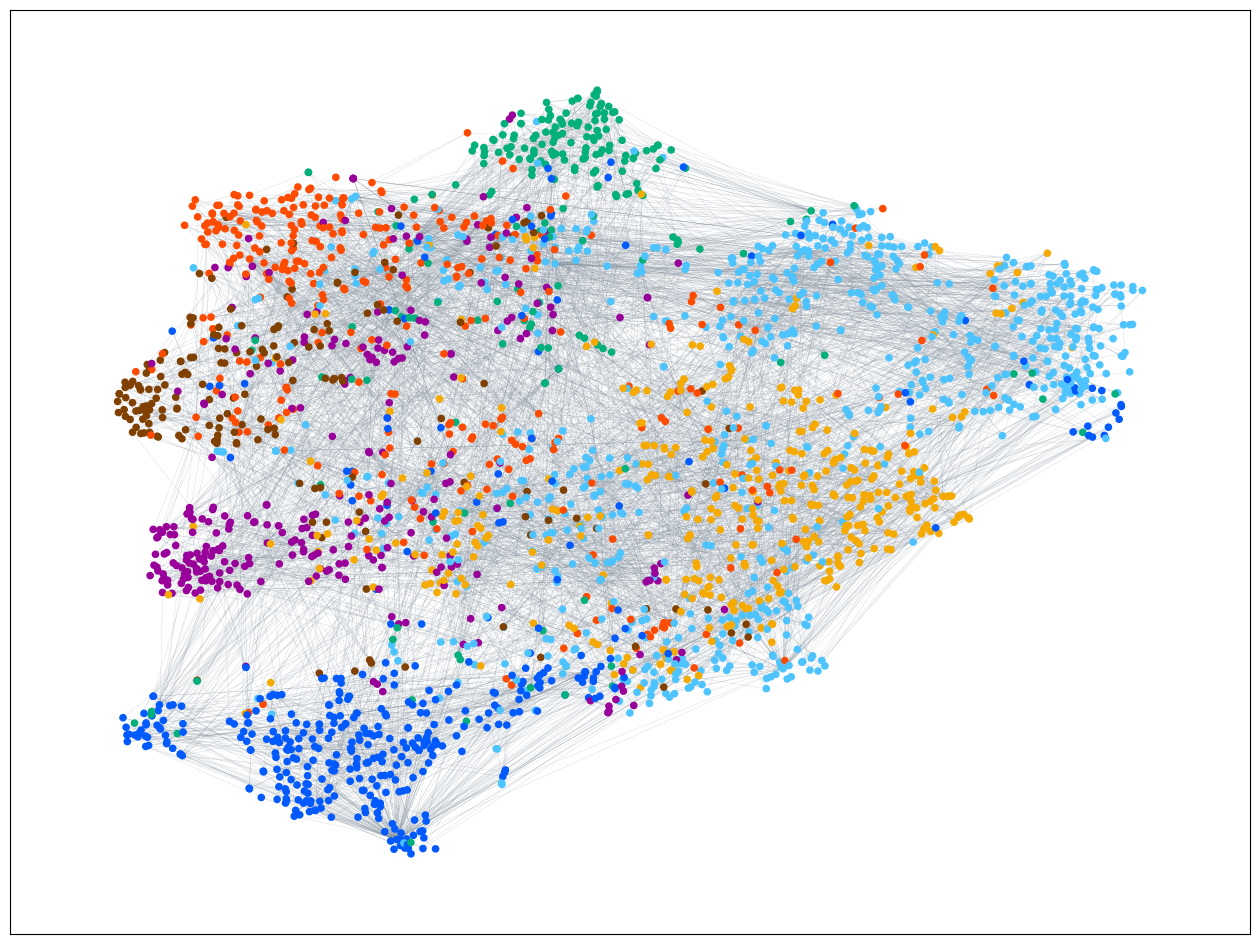

In [17]:
# GCN における1層目の線形変換（集約前）によって得られた特徴ベクトル H_tsne を2次元に圧縮し、
# それをノードの座標としてネットワークを可視化する。
# 各ノードはラベルに対応した色（cs）で塗り分けられている。

fig, ax = plt.subplots(figsize=(16, 12))  # 描画サイズを指定して図を作成
nx.draw_networkx(
    G,  # グラフ構造（NetworkXオブジェクト）
    ax=ax,  # 描画先のAxesオブジェクト
    pos=H_tsne,  # 各ノードの位置（t-SNEにより次元削減された特徴ベクトル）
    node_size=20,  # ノードの大きさ
    node_color=cs,  # ノードの色（クラスごとのラベルに基づく）
    labels={i: "" for i in range(n)},  # ラベル非表示（空文字）
    edge_color="#84919e",  # エッジの色
    width=0.1,  # エッジの太さ
)